# Multiproduct Linear Monopolist (Schmalensee)

In [2]:
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from math import sqrt, ceil
from timeit import default_timer as timer
from datetime import timedelta
import itertools
import sys
sys.path.append('..')
from modules import LinearMonopolist

## Single resolution

model id = LinearMonopolist_N100_2024-04-05_18-23-35


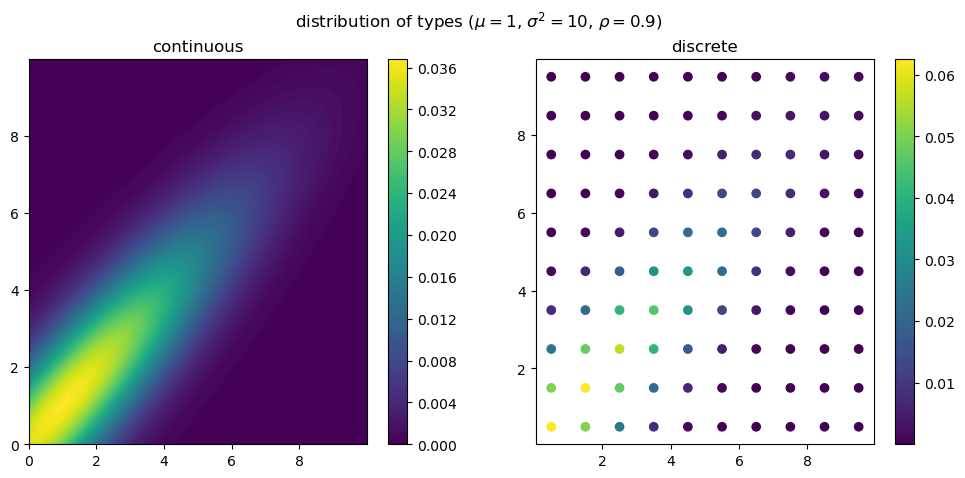

In [63]:
n0, n1 = 10, 10
t0, t1 =  np.linspace(0, 10, num=n0+1, dtype=np.float32), np.linspace(0, 10, num=n1+1, dtype=np.float32)  #  [1, 1.5, 3], [0, 0.5, 1]
theta0 = (t0[1:]+t0[:-1])/2 ; theta1 = (t1[1:]+t1[:-1])/2
theta0, theta1 = np.meshgrid(theta0,theta1)
theta = np.stack((theta0.flatten(), theta1.flatten())); N = theta.shape[-1] # number of types

mu = 1; sigma2 = 10; rho = 0.9
distribution = multivariate_normal(mu*np.array([1, 1]), sigma2*np.array([[1, rho], [rho,1]]))
cd = distribution.cdf(np.dstack(np.meshgrid(t0,t1)))
f = cd[1:,1:] + cd[:-1,:-1] - cd[1:,:-1] - cd[:-1,1:]
f = f.flatten() /  np.sum(f) # weights in the distribution

### Model parameters setting
param = {'substituable':False, 'mu':mu, 'simga2':sigma2, 'rho':rho}   # False for indivisible goods (constraints = cube), True for substituable goods (constraints = simplex)

### Objects
model = LinearMonopolist(theta, f, param)

fig, axs = plt.subplots(1,2, figsize=(12,5))
c0, c1 = np.mgrid[np.min(t0):np.max(t0):0.01, np.min(t1):np.max(t1):0.01]
ctypes = axs[0].contourf(c0, c1, distribution.pdf(np.dstack((c0, c1))), 100)
_ = fig.colorbar(ctypes)
_ = axs[0].set_title('continuous')
dtypes = axs[1].scatter(theta0, theta1, c=f)
_ = fig.colorbar(dtypes)
_ = axs[1].set_title('discrete')
_ = fig.suptitle(rf'distribution of types ($\mu=${mu}, $\sigma^2=${sigma2}, $\rho=${rho})')


In [38]:
# path = 'results/Schmalensee/'+model.id+'_distribution'
# fig.savefig(path, bbox_inches="tight", pad_inches=0.05)

In [64]:
kmax = ceil(sqrt(N))+1
df_prices = pd.DataFrame(columns=['mu', 'sigma2', 'rho', 'p', 'b', 'convergence', 'deterministic'])

print(f'mu={mu}, sigma2={sigma2}, rho={rho}\n')

# t_start = timer()
model.local(); k = 0; test = False
while k < kmax and np.any(test==False):
    k += 1
    print(f'OPTIMIZATION {k}: {len(model.indices)} IC constraints')
    model.solve(warmstart=True, it_max = 1e4, stepratio=0.1, log=1) # path='results/'+model.id) #sqrt(len(model.indices)) #len(model.indices)
    # model.residuals()
    print(f'IC constraints: {len(model.IC_binding)} binding, {len(model.IC_violated)} violated\n')
    # model.indices = sorted(set(model.indices).union(model.IC_violated))
    model.indices = sorted(set(model.indices).union(set(model.IC_violated).intersection(model.ind_local(k*ceil(sqrt(N))))))
    model.local(model.indices)
    test = np.array([model.converged, len(model.IC_violated)==0])
# elapsed = timer() - t_start
# print(f'elapsed time = {str(timedelta(seconds=elapsed))}')
if model.converged == False:
    model.solve(warmstart=True, stepratio=0.1, it_max=1e5, tol_primal=1e-6, tol_dual=1e-6, scale=True,)

model.output(log=0)
prices = np.unique(model.p.round(6))
df_prices.loc[len(df_prices)] = [mu, sigma2, rho,  prices[1], prices[-1], model.converged, len(prices)==3]
print(f'nb of optimization = {k}, final convergence = {model.converged}, deterministic solution = {len(prices)==3}\n')

# model.solve(warmstart=True, stepratio=0.5, it_max=1e5, tol_primal=1e-6, tol_dual=1e-6, scale=True,) #path='results/'+model.id
# model.residuals(title='residuals')

mu=1, sigma2=10, rho=0.9

OPTIMIZATION 1: 180 IC constraints
convergence = False, iterations = 10000, elapsed time = 0:00:11.496202
primal residual = 5.83e-01 tol, dual residual = 1.94e+00 tol
primal-dual gap = 1.32e-04, optimal value - current value < 3.93e-05 optimal value
IC constraints: 174 binding, 595 violated

OPTIMIZATION 2: 327 IC constraints
convergence = False, iterations = 10000, elapsed time = 0:00:09.227430
primal residual = 2.03e+01 tol, dual residual = 7.00e+00 tol
primal-dual gap = 1.23e-04, optimal value - current value < 3.65e-05 optimal value
IC constraints: 262 binding, 378 violated

OPTIMIZATION 3: 448 IC constraints
convergence = False, iterations = 10000, elapsed time = 0:00:08.463127
primal residual = 2.12e+01 tol, dual residual = 6.61e+00 tol
primal-dual gap = 3.04e-04, optimal value - current value < 9.18e-05 optimal value
IC constraints: 344 binding, 16 violated

OPTIMIZATION 4: 459 IC constraints
convergence = False, iterations = 10000, elapsed time = 0:00:

In [22]:
# model.solve(warmstart=True, stepratio=10, it_max=1e5, tol_primal=1e-6, tol_dual=1e-6, scale=True,) 
# model.residuals(title='residuals')

In [35]:
df_prices


,mu,sigma2,rho,p,b,convergence,deterministic
0,7.5,10,0.9,5.5,11.0,True,True


In [44]:
model.p

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.50000000e+00,  6.50000000e+00,
        6.50000000e+00,  6.50000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.76471554e-17,  0.00000000e+00,  0.00000000e+00,
        6.50000000e+00,  6.50000000e+00,  6.50000000e+00,  6.50000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.84314369e-17,
       -1.84314369e-17, -1.84314369e-17,  6.50000000e+00,  6.50000000e+00,
        6.50000000e+00,  6.50000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.97648797e-16, -1.65882932e-16, -1.65882932e-16,
        6.50000000e+00,  6.50000000e+00,  6.50000000e+00,  6.50000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.84314369e-17,
       -1.65882932e-16, -1.65882932e-16,  6.50000000e+00,  6.50000000e+00,
        6.50000000e+00,  6.50000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

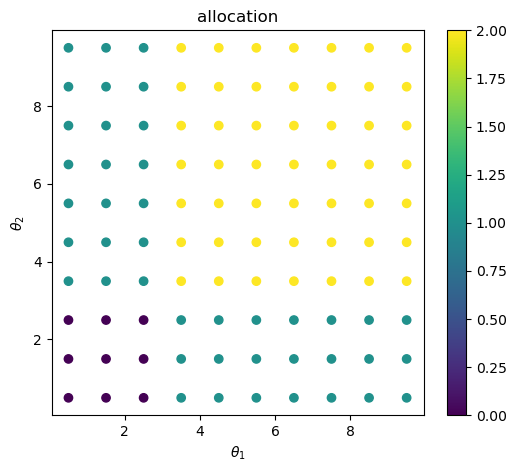

In [50]:
model.display(model.y[:N]+model.y[N:], title='allocation', figsize=(6,5))

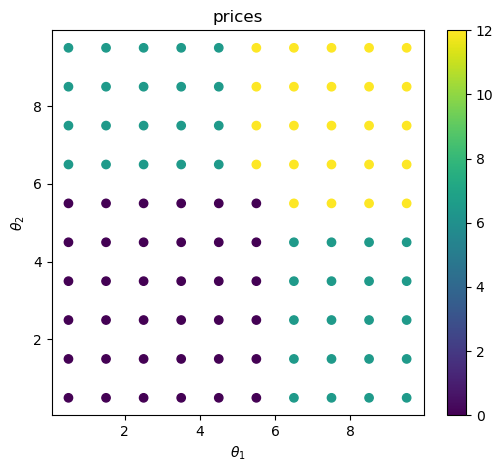

In [46]:
model.display(model.p, title='prices', figsize=(6,5))

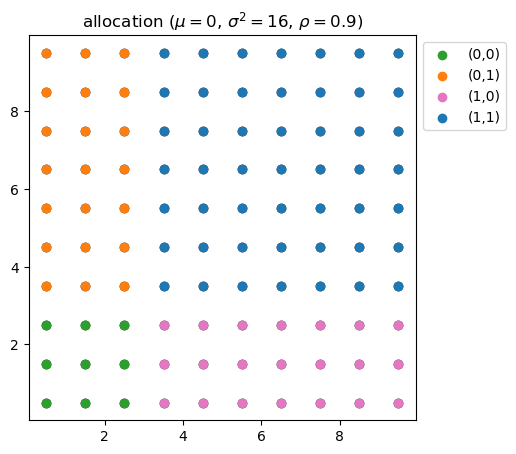

In [51]:
atol = 1e-6
y0_0 = np.isclose(model.y[:model.N],0, atol=atol)
y0_1 = np.isclose(model.y[:model.N],1, atol=atol, rtol=0)
y1_0 = np.isclose(model.y[model.N:],0, atol=atol)
y1_1 = np.isclose(model.y[model.N:],1, atol=atol, rtol=0)

y_00 = np.flatnonzero(np.logical_and(y0_0, y1_0))
y_01 = np.flatnonzero(np.logical_and(y0_0, y1_1))
y_10 = np.flatnonzero(np.logical_and(y0_1, y1_0))
y_11 = np.flatnonzero(np.logical_and(y0_1, y1_1))

fig, ax = plt.subplots(figsize=(5,5))
_ = ax.scatter(theta[0], theta[1], facecolors='w',edgecolors='k')
_ = ax.scatter(theta[0, y_00], theta[1, y_00], c='tab:green', label='(0,0)')
_ = ax.scatter(theta[0, y_01], theta[1, y_01], c='tab:orange', label='(0,1)')
_ = ax.scatter(theta[0, y_10], theta[1, y_10], c='tab:pink', label='(1,0)')
_ = ax.scatter(theta[0, y_11], theta[1, y_11], c='tab:blue', label='(1,1)')
_ = ax.legend(bbox_to_anchor=(1, 1),loc='upper left') #bbox_to_anchor=(0., -.13, 1., .1), loc='lower left', ncols=4, mode="expand", borderaxespad=0.) #(bbox_to_anchor=(1.02, 1.), loc='lower right')
_ = ax.set_title(rf'allocation ($\mu=${mu}, $\sigma^2=${sigma2}, $\rho=${rho})')


In [ ]:
# fig, axs = plt.subplots(1,2, figsize=(13,5),) # subplot_kw=dict(aspect='equal',))
# item1 = axs[0].scatter(theta[0], theta[1], c = model.y[:model.N], cmap='rainbow')
# _ = fig.colorbar(item1)
# _ = axs[0].set_title('probability of allocating item 1')
# item2 = axs[1].scatter(theta[0], theta[1], c = model.y[model.N:], cmap='rainbow')
# _ = fig.colorbar(item2)
# _ = axs[1].set_title('probability of allocating item 2')
# # _ = fig.suptitle(f'c = {c}')

In [ ]:
model.range(title='Product range', ) #path='results/'+model.id+'_products')

In [ ]:
# path = 'results/Schmalensee/'+model.id+'_allocation'
# fig.savefig(path, bbox_inches="tight", pad_inches=0.05)

## Multiple resolutions

In [3]:
n0, n1 = 10, 10
t0, t1 =  np.linspace(0, 10, num=n0+1, dtype=np.float32), np.linspace(0, 10, num=n1+1, dtype=np.float32)  #  [1, 1.5, 3], [0, 0.5, 1]
theta0 = (t0[1:]+t0[:-1])/2 ; theta1 = (t1[1:]+t1[:-1])/2
theta0, theta1 = np.meshgrid(theta0,theta1)
theta = np.stack((theta0.flatten(), theta1.flatten())); N = theta.shape[-1] # number of types

kmax = ceil(sqrt(N))+1
df_prices = pd.DataFrame(columns=['mu', 'sigma2', 'rho', 'p', 'b', 'convergence', 'deterministic', 'model id'])

sigma2 = 12
for mu, rho in itertools.product([2.5, 5, 7.5], [0.25, 0.5, 0.75]):
    print(f'mu={mu}, rho={rho}')

    distribution = multivariate_normal(mu*np.array([1, 1]), sigma2*np.array([[1, rho], [rho,1]]))
    cd = distribution.cdf(np.dstack(np.meshgrid(t0,t1)))
    f = cd[1:,1:] + cd[:-1,:-1] - cd[1:,:-1] - cd[:-1,1:]
    f = f.flatten() /  np.sum(f) # weights in the distribution

    ### Model parameters setting
    param = {'substituable':False, 'mu':mu, 'simga2':sigma2, 'rho':rho}   # False for indivisible goods (constraints = cube), True for substituable goods (constraints = simplex)

    ### Objects
    model = LinearMonopolist(theta, f, param)
    
    ### Resolution
    # t_start = timer()
    model.local(); k = 0; test = False
    while k < kmax and np.any(test==False):
        k += 1
        # print(f'OPTIMIZATION {k}: {len(model.indices)} IC constraints')
        model.solve(warmstart=True, it_max = 1e4, stepratio=0.1, log=0, ) #path='results/Schmalensee/'+model.id) #sqrt(len(model.indices)) #len(model.indices)
        # model.residuals()
        # print(f'IC constraints: {len(model.IC_binding)} binding, {len(model.IC_violated)} violated\n')
        # model.indices = sorted(set(model.indices).union(model.IC_violated))
        model.indices = sorted(set(model.indices).union(set(model.IC_violated).intersection(model.ind_local(k*ceil(sqrt(N))))))
        model.local(model.indices)
        test = np.array([model.converged, len(model.IC_violated)==0])
    # elapsed = timer() - t_start
    # print(f'elapsed time = {str(timedelta(seconds=elapsed))}')
    if model.converged == False:
        k +=1
        model.solve(warmstart=True, stepratio=0.1, it_max=1e5, tol_primal=1e-6, tol_dual=1e-6, scale=True, log=0) 

    model.output(log=0, path='results/Schmalensee/'+model.id)
    prices = np.unique(model.p.round(6))
    df_prices.loc[len(df_prices)] = [mu, sigma2, rho,  prices[1], prices[-1], model.converged, len(prices)==3, model.id]
    print(f'nb of optimization = {k}, final convergence = {model.converged}, deterministic solution = {len(prices)==3}\n')

# df_prices.loc[:,['mu', 'rho', 'p', 'b']]

path = 'results/Schmalensee/prices_N'+str(model.N)
with pd.ExcelWriter(path+'.xlsx') as writer:  
                df_prices.round(3).to_excel(writer, sheet_name='prices')
                
df_prices

mu=2.5, rho=0.25
model id = LinearMonopolist_N100_2024-04-05_18-02-52
nb of optimization = 1, final convergence = True, deterministic solution = True

mu=2.5, rho=0.5
model id = LinearMonopolist_N100_2024-04-05_18-02-56
nb of optimization = 3, final convergence = True, deterministic solution = True

mu=2.5, rho=0.75
model id = LinearMonopolist_N100_2024-04-05_18-03-22
convergence = True, iterations = 79053, elapsed time = 0:00:10.120056
primal residual = 9.95e-01 tol, dual residual = 1.41e-01 tol
primal-dual gap = 1.75e-06, optimal value - current value < 4.98e-07 optimal value
nb of optimization = 12, final convergence = True, deterministic solution = False

mu=5, rho=0.25
model id = LinearMonopolist_N100_2024-04-05_18-04-14
nb of optimization = 1, final convergence = True, deterministic solution = True

mu=5, rho=0.5
model id = LinearMonopolist_N100_2024-04-05_18-04-16
nb of optimization = 1, final convergence = True, deterministic solution = True

mu=5, rho=0.75
model id = LinearMon

,mu,sigma2,rho,p,b,convergence,deterministic,model id
0,2.5,4,0.25,3.500000,5.0,True,True,LinearMonopolist_N100_2024-04-05_18-02-52
1,2.5,4,0.50,3.500000,6.0,True,True,LinearMonopolist_N100_2024-04-05_18-02-56
2,2.5,4,0.75,2.500000,5.0,True,False,LinearMonopolist_N100_2024-04-05_18-03-22
3,5.0,4,0.25,5.500000,8.0,True,True,LinearMonopolist_N100_2024-04-05_18-04-14
4,5.0,4,0.50,4.500000,8.0,True,True,LinearMonopolist_N100_2024-04-05_18-04-16
5,5.0,4,0.75,4.500000,9.0,True,True,LinearMonopolist_N100_2024-04-05_18-04-19
6,7.5,4,0.25,7.500000,12.0,True,True,LinearMonopolist_N100_2024-04-05_18-04-40
7,7.5,4,0.50,6.500000,12.0,True,True,LinearMonopolist_N100_2024-04-05_18-04-42
8,7.5,4,0.75,3.496455,12.0,False,False,LinearMonopolist_N100_2024-04-05_18-04-50


In [ ]:
# path = 'results/Schmalensee/prices_N'+str(model.N)
# with pd.ExcelWriter(path+'.xlsx') as writer:  
#                 df_prices.round(3).to_excel(writer, sheet_name='prices')
# with pd.option_context(#'display.max_rows', None,
#                         'display.max_columns', None,
#                         'display.precision', 3,):
#         print(df_prices)